In [1]:
from numpy import *
from scipy import signal
from scipy.integrate import quad
import TMQGP as tm
import tqdm.notebook as tqdm
from QuarkTM import Particle, Channel

In [25]:
from syntax_sugar import pipe, END
from syntax_sugar import thread_syntax as t, process_syntax as p

NTHR = 14

In [26]:
mQ = 0.6
mG = 0.9

In [27]:
T = 0.15

params = {'G' : 4., 'L' : 1, 'screen' : 1.5}

In [28]:
erange = linspace(-5, 5, 101)
qrange = linspace(0, 5, 31)

eps = 0.05
quark_run = Particle(mQ, qrange, erange, eps=eps)
gluon_run = Particle(mG, qrange, erange, eps=eps, stat='b', d=16)

In [29]:
import os

In [30]:
out_folder = './output/QG_fakeFa/'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [43]:
Trange = arange(0.15, 0.35, 0.05)[::-1]

In [44]:
quark_run.d

6

In [49]:
Trange

array([0.3 , 0.25, 0.2 , 0.15])

In [50]:
%matplotlib qt

In [51]:
plt.show()

In [52]:
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])*10

In [53]:
%matplotlib qt

for T in Trange:
    print(T)
    chss = []
    pts = []

    delta = 1
    
    Nf = 3
    
    fig, ax = plt.subplots(2, 4, figsize=(16, 9))
#     ax = _ax.flatten()
    n_iter = 0
    
    while abs(delta) > 1e-4:
    #     ch_QQ = Channel(quark_run, quark_run, T, G=G, ds=4, da=1)
    #     ch_GG = Channel(gluon_run, gluon_run, T, G=G, ds=9, da=1, Fa=9/4)
    #     ch_QG = Channel(quark_run, gluon_run, T, G=G, ds=6, da=3, Fa=9/8)
    #     ch_GQ = Channel(gluon_run, quark_run, T, G=G, ds=6, da=3, Fa=9/8)

    #     channels_Q = [ch_QQ, ch_QG]
    #     channels_G = [ch_GG, ch_GQ]

        channels_Q = dict()

#         channels_Q['qq3'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=3, Fa=1/2, screen=screen)
#         channels_Q['qq6'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=6, Fa=1/4, screen=screen)
        channels_Q['qa1'] = Channel(quark_run, quark_run, T, ds=4, da=1, Fa=1, **params)
#         channels_Q['qa8'] = Channel(quark_run, quark_run, T, G=G, ds=4, da=8, Fa=1/8, screen=screen)

        channels_Q['qg3'] = Channel(quark_run, gluon_run, T, ds=4, da=3, Fa=9/8, **params)
    #     channels_Q['qg6'] = Channel(quark_run, gluon_run, T, G=G, ds=4, da=6, Fa=3/8, screen=screen)
    #     channels_Q['qg15'] = Channel(quark_run, gluon_run, T, G=G, ds=4, da=15, Fa=3/8, screen=screen)

        channels_G = dict()
# 
        channels_G['gq3'] = Channel(gluon_run, quark_run, T, ds=4, da=3, Fa=9/8, **params)
    #     channels_G['gq6'] = Channel(gluon_run, quark_run, T, G=G, ds=4, da=6, Fa=3/8, screen=screen)
    #     channels_G['gq15'] = Channel(gluon_run, quark_run, T, G=G, ds=4, da=15, Fa=3/8, screen=screen)

        channels_G['gg1'] = Channel(gluon_run, gluon_run, T, ds=4, da=1, Fa=1, **params)
    #     channels_G['gg16'] = Channel(gluon_run, gluon_run, T, G=G, ds=4, da=16, Fa=9/8, screen=screen)
    #     channels_G['gg27'] = Channel(gluon_run, gluon_run, T, G=G, ds=4, da=27, Fa=3/4, screen=screen)

        channels = {k : c for k, c in list(channels_G.items()) + list(channels_Q.items())}
        
        for k, ch in channels.items():
            np.savetxt(out_folder + f'{k}_vq.dat', ch.v(ch.qrange))
            np.savetxt(out_folder + f'{k}_weights', array([ch.ds, ch.da, ch.Fa]))
        
        for k, ch in channels.items():
            print(k)
            ch.populate_T()
            
            if k == 'qa1':
#                 print('plotting', k)
                ax[0][0].plot(erange, imag(ch.TM[:, 0]), label='iter %i'%n_iter, c=colors[n_iter])
                ax[0][0].set_xlim(0, 2.5)
                ax[0][0].legend()
                
            if k == 'gg1':
#                 print('plotting', k)
                ax[1][0].plot(erange, imag(ch.TM[:, 0]), label='iter %i'%n_iter,  c=colors[n_iter])
                ax[1][0].set_xlim(-2.5, 2.5)
#                 ax[3].legend()

            if k == 'qg3':
#                 print('plotting', k)
                ax[0][3].plot(erange, imag(ch.TM[:, 0]), label='iter %i'%n_iter, c=colors[n_iter])
                ax[0][3].set_xlim(0, 2.5)
                ax[0][3].legend()
                
            if k == 'gq3':
#                 print('plotting', k)
                ax[1][3].plot(erange, imag(ch.TM[:, 0]), label='iter %i'%n_iter,  c=colors[n_iter])
                ax[1][3].set_xlim(0, 2.5)
                
            plt.pause(0.1)
            
        for k, ch in channels.items():
            
            ############### dirty parallelization ################
            ress = []
            for q in tqdm.tqdm(ch.qrange):
                if (ch.func != tm.sigma_ff_onshell and ch.func != tm.sigma_bb_onshell
                        and ch.func != tm.sigma_fb_onshell and ch.func != tm.sigma_bf_onshell):
#                     res = pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, ch.p_j.R)]*(NTHR//1) | END
#                     ress += [res]
                    raise
                else:
                    eps1 = tm.Interpolator(ch.qrange, ch.p_i.om0(ch.qrange), 'linear')
                    eps2 = tm.Interpolator(ch.qrange, ch.p_j.om0(ch.qrange), 'linear')
                    res = pipe(ch.erange) | p[lambda z: ch.func(z, q, ch.T, ch.iImT, 
                                                                ch.p_j.R, eps1, eps2)]*(NTHR//1) | END
                    ress += [res]

            ress = array(ress).transpose()
#             break
            ch.ImS = ress
#             if ch.p_i.stat == 'b':
#                 ress_new = []
#                 for res in ch.ImS:
#                     iImSigma = tm.Interpolator(self.erange, np.ascontiguousarray(res), 'cubic')
#                     ImS_new = []
#                     for e in self.erange:
#                         if e < 0:
#                             ImS_new += [-iImSigma(-e)]
#                         else:
#                             ImS_new += [iImSigma(e)]
#                     ress_new += [ImS_new]

#                 ress_cm = np.array(ress_new).transpose()
#                 self.ImS = ress_cm

            ReSigmas = []

            for res in tqdm.tqdm(ch.ImS.transpose()):
                iImSigma = tm.Interpolator(ch.erange, np.ascontiguousarray(res), 'cubic')
                ReSigma = [tm.ReSigmaKK(e, iImSigma) for e in ch.erange]
                ReSigmas += [ReSigma]

            ch.ReS = np.array(ReSigmas).transpose()


            ############### Serial version #################

    #         ch.populate_S()
    #     break
        
        
        
        ImS_Q = sum([c.Nf * c.ds * c.da * c.ImS / c.p_i.d for k, c in channels_Q.items()], axis=0)
        ReS_Q = sum([c.Nf * c.ds * c.da * c.ReS / c.p_i.d for k, c in channels_Q.items()], axis=0)

        ax[0][1].plot(erange, ImS_Q[:, 0], c=colors[n_iter])
        ax[0][1].set_xlim(-1, 3)
        
        om0_k = np.array([quark_run.om0(quark_run.qrange) for e in quark_run.erange])
        arrE = np.array([quark_run.erange for q in quark_run.qrange]).transpose()

        G_Q_new = 1/(arrE - om0_k + 0*1j*quark_run.eps - (ReS_Q + 1j*ImS_Q))

    #     quark_new = Particle(quark_run.m, qrange, erange, eps=2e-2, R=-2*imag(G_Q_new))
        quark_new = Particle(quark_run.m, qrange, erange, eps=quark_run.eps, Gtab=G_Q_new)
        
        quark_new.S = ReS_Q + 1j*ImS_Q
        
        ImS_G = sum([c.Nf * c.ds * c.da *c.ImS / c.p_i.d for c in channels_G.values()],
               axis=0)
        
        ReS_G = sum([c.Nf * c.ds * c.da *c.ReS / c.p_i.d for c in channels_G.values()],
               axis=0)

        
        ax[1][1].plot(erange, ImS_G[:, 0])
        ax[1][1].set_xlim(-0, 3)
        
        om0_k = np.array([gluon_run.om0(gluon_run.qrange) for e in gluon_run.erange])
        arrE = np.array([gluon_run.erange for q in gluon_run.qrange]).transpose()

    #     G_G_new = 1/(arrE**2 - om0_k**2 + 2*1j*gluon_run.eps*arrE - (ReS_G + 1j*ImS_G))
        G_G_new = 1/(arrE - om0_k + 0*1j*gluon_run.eps - (ReS_G + 1j*ImS_G))
    #     gluon_new = Particle(gluon_run.m, qrange, erange, eps=2e-2, stat='b', d=16, R=-2*imag(G_G_new))
        gluon_new = Particle(gluon_run.m, qrange, erange, eps=gluon_run.eps, stat='b', d=16, Gtab=G_G_new)
        
        gluon_new.S = ReS_G + 1j*ImS_G
        
        chss += [[channels_Q, channels_G]]
        pts += [[quark_run, gluon_run]]

        delta = 0
        delta += sqrt(sum((quark_new.Rtab - quark_run.Rtab)**2)) / len(erange) / len(qrange)
#         delta += sum(quark_new.Rtab / quark_run.Rtab) / len(erange) / len(qrange)
        delta += sqrt(sum((gluon_new.Rtab - gluon_run.Rtab)**2)) / len(erange) / len(qrange)
        delta /= 2
        print(delta)
    
        quark_bup = quark_run

        quark_run = quark_new
        gluon_run = gluon_new
        
        ax[0][2].plot(erange, quark_new.Rtab[:, 0], c=colors[n_iter])
        ax[1][2].plot(erange, gluon_new.Rtab[:, 0], c=colors[n_iter])
        ax[0][2].set_xlim(-1, 3)
        ax[1][2].set_xlim(0, 3)
        plt.pause(0.1)
        n_iter += 1


    cQ, cG = chss[-1]

    for k, c in cQ.items():
        np.savetxt(out_folder + 'Q_TM_'+k+'_T=%.3f.dat'%T, c.TM)
        np.savetxt(out_folder + 'Q_X_'+k+'_T=%.3f.dat'%T, c.X)
        np.savetxt(out_folder + 'Q_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
        np.savetxt(out_folder + 'Q_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)

    for k, c in cG.items():
        np.savetxt(out_folder + 'G_TM_'+k+'_T=%.3f.dat'%T, c.TM)
        np.savetxt(out_folder + 'G_X_'+k+'_T=%.3f.dat'%T, c.X)
        np.savetxt(out_folder + 'G_ImS_'+k+'_T=%.3f.dat'%T, c.ImS)
        np.savetxt(out_folder + 'G_ReS_'+k+'_T=%.3f.dat'%T, c.ReS)



    np.savetxt(out_folder + 'Q_Rho_T=%.3f.dat'%T, pts[-1][0].Rtab)
    np.savetxt(out_folder + 'G_Rho_T=%.3f.dat'%T, pts[-1][1].Rtab)

    np.savetxt(out_folder + 'Q_G_T=%.3f.dat'%T, pts[-1][0].Gtab)
    np.savetxt(out_folder + 'G_G_T=%.3f.dat'%T, pts[-1][1].Gtab)
    
    np.savetxt(out_folder + 'Q_S_T=%.3f.dat'%T, pts[-1][0].S)
    np.savetxt(out_folder + 'G_S_T=%.3f.dat'%T, pts[-1][1].S)

    np.savetxt(out_folder + 'erange_T=%.3f.dat'%T, erange)
    np.savetxt(out_folder + 'qrange_T=%.3f.dat'%T, qrange)
    
    plt.close()
    

0.30000000000000004
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.00850904346105447
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.00921705239260586
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.0011679485000899278
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.0003172846010084271
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

4.697394693362206e-05
0.25
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.0025786178834337546
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.002657549451235166
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.00040311383095825834
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

9.99957163867996e-05
0.2
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.004721977147045866
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.004604507668983852
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.0014437883178607608
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.00046721600024478586
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.00012235278077588556
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

3.426582210261988e-05
0.15
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.013371120130448107
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.013010316586757373
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.013555399269054145
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.0018040044929873227
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.004065748072547046
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.008626854283210101
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.02597275941694136
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.01028653917526479
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.03223183745572741
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.025605533063453294
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

0.05326034820396605
gq3


  0%|          | 0/101 [00:00<?, ?it/s]

gg1


  0%|          | 0/101 [00:00<?, ?it/s]

qa1


  0%|          | 0/101 [00:00<?, ?it/s]

qg3


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
plt.close()

## Plots

In [145]:
%matplotlib inline

In [134]:
i1 = 9
i2 = 8

In [137]:
ch_gg1_1 = chss[i1][1]['gg1']
ch_gg1_2 = chss[i2][1]['gg1']

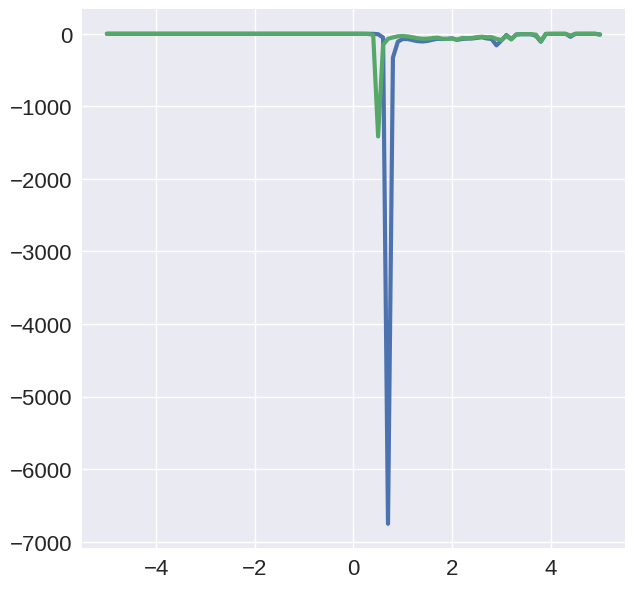

In [146]:
plt.plot(erange, imag(ch_gg1_1.TM[:, 0]))
plt.plot(erange, imag(ch_gg1_2.TM[:, 0]))

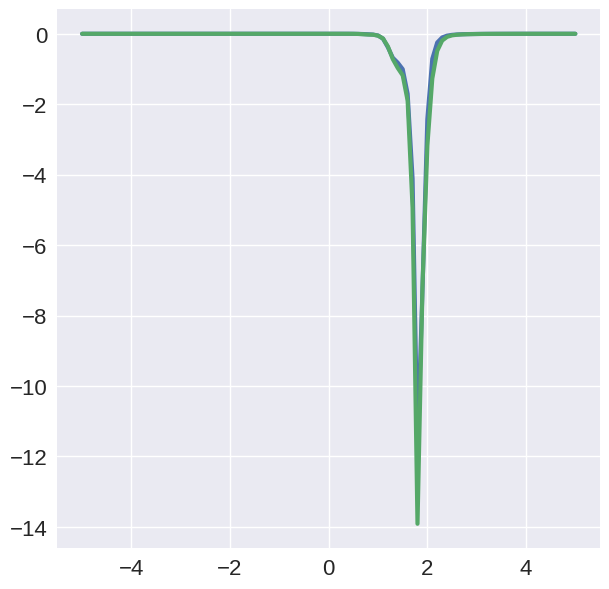

In [147]:
plt.plot(erange, ch_gg1_1.ImG2[:, 0])
plt.plot(erange, ch_gg1_2.ImG2[:, 0])

In [139]:
G1 = pts[i1][1]
G2 = pts[i2][1]

In [148]:
ch1_new = Channel(G1, G1, T, ds=4, da=1, Fa=9/4, **params)
ch2_new = Channel(G2, G2, T, ds=4, da=1, Fa=9/4, **params)

In [149]:
ch1_new.populate_T()
ch2_new.populate_T()

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

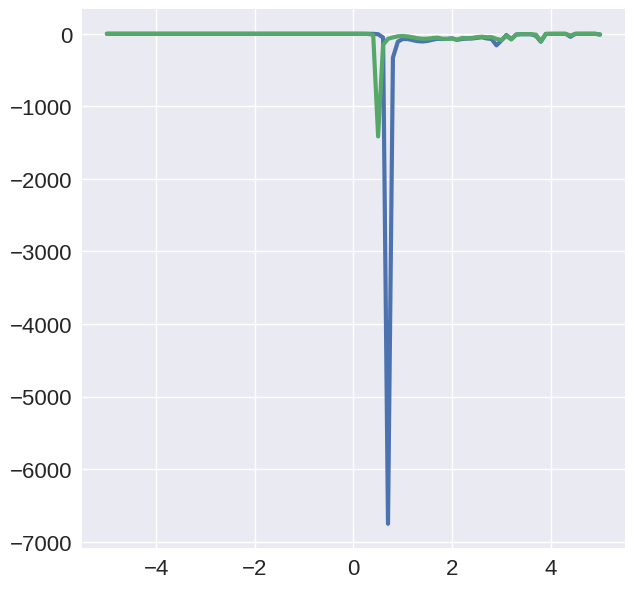

In [151]:
plt.plot(erange, imag(ch1_new.TM[:, 0]))
plt.plot(erange, imag(ch2_new.TM[:, 0]))

(0.0, 2.0)

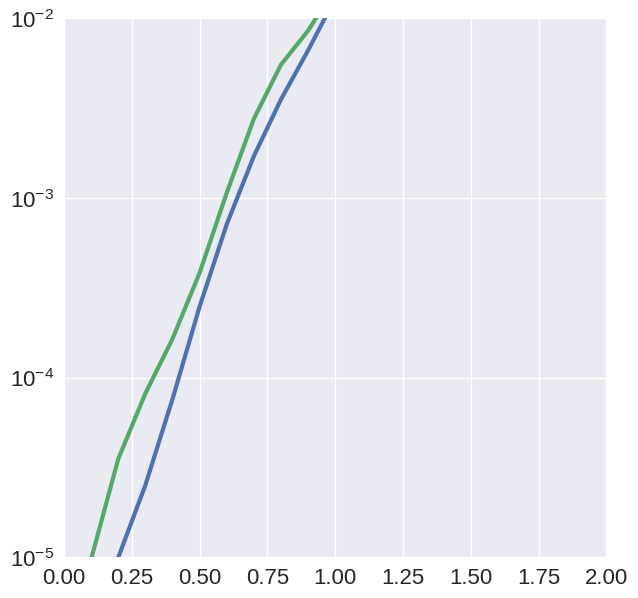

In [160]:
plt.plot(erange, imag(ch1_new.X[:, 0]))
plt.semilogy(erange, imag(ch2_new.X[:, 0]))

plt.ylim(1e-5, 1e-2)
plt.xlim(0, 2)

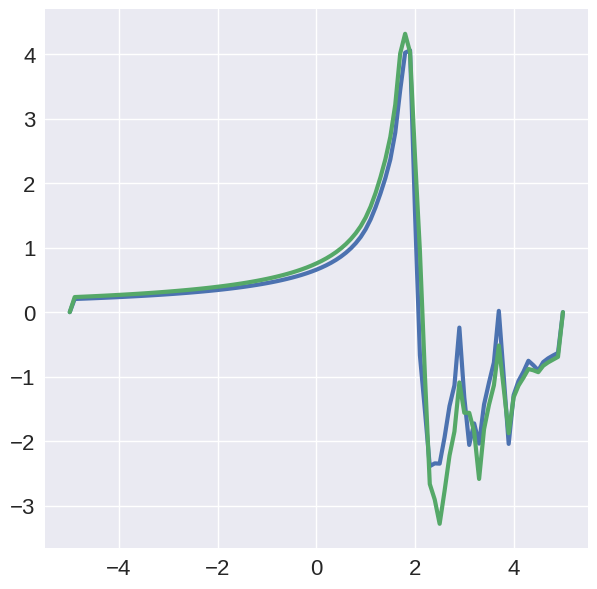

In [155]:
plt.plot(erange, real(ch1_new.X[:, 0]))
plt.plot(erange, real(ch2_new.X[:, 0]))

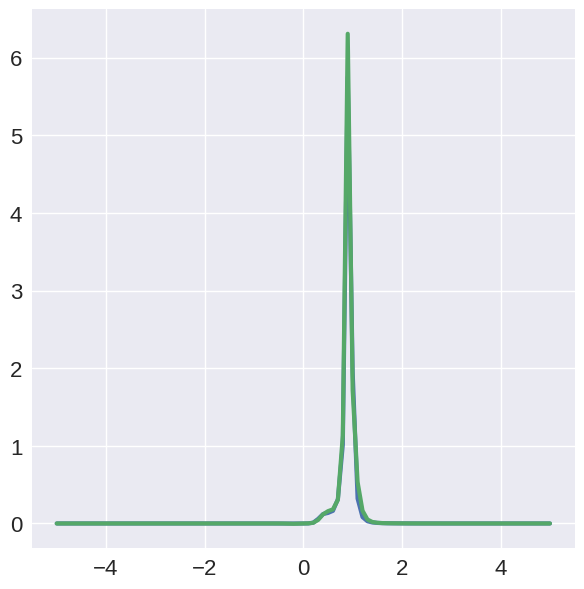

In [141]:
plt.plot(erange, G1.Rtab[:, 0])
plt.plot(erange, G2.Rtab[:, 0])

In [131]:
import mpld3

In [132]:
mpl

## Test qg and gq 

In [ ]:
ch_gg = Channel(gluon_run, gluon_run, T, ds=4, da=1, Fa=9/4, **params)


In [42]:
ch_gg.populate_T()

  0%|          | 0/201 [00:00<?, ?it/s]

In [49]:
%matplotlib inline

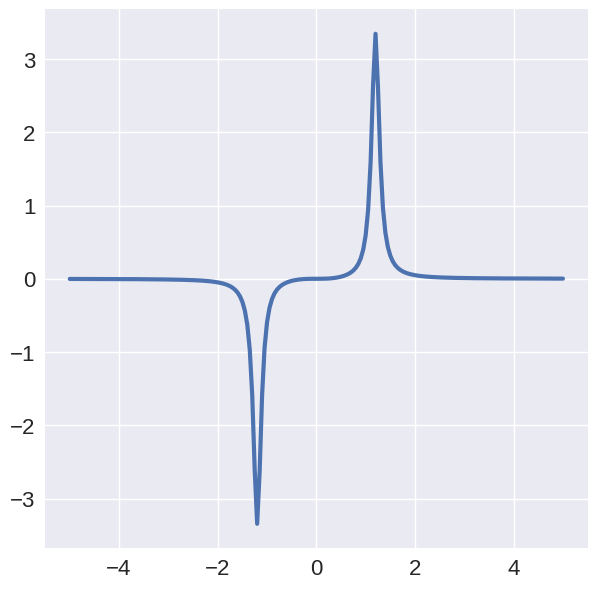

In [53]:
plt.plot(erange, gluon_run.Rtab[:, 0])

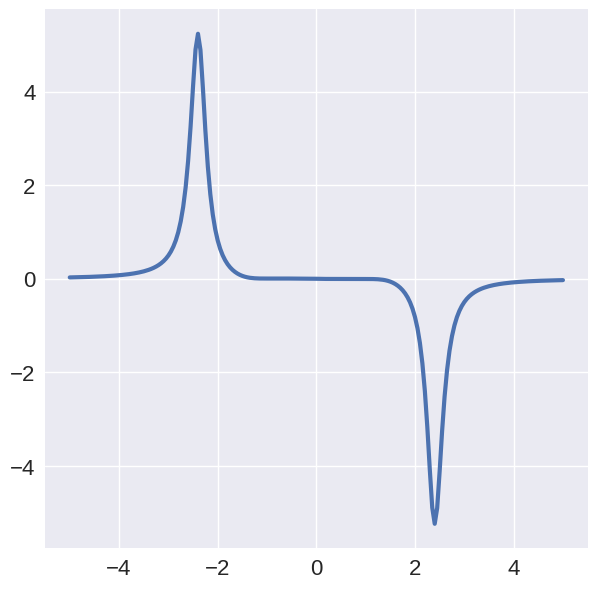

In [52]:
plt.plot(erange, ch_gg.ImG2[:, 0])

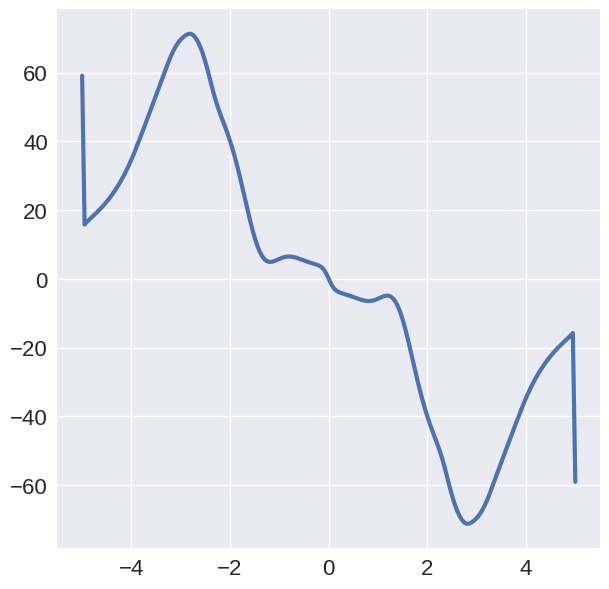

In [51]:
plt.plot(erange, imag(ch_gg.TM[:, 0]))

In [15]:
Q, G = pts[-1]

IndexError: list index out of range

In [27]:
chss[0]

[{'qa1': <QuarkTM.Channel at 0x7f049c8fe790>,
  'qg3': <QuarkTM.Channel at 0x7f04c0174590>},
 {'gq3': <QuarkTM.Channel at 0x7f049ce2f190>,
  'gg1': <QuarkTM.Channel at 0x7f049c8a9090>}]

In [28]:
plt.plot(erange, chss[0][1]['gg1'].TM[:, 0])

/usr/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [24]:
i = 3

ch_qa1 = chss[i][0]['qa1']
pt_q = pts[i+1][0]

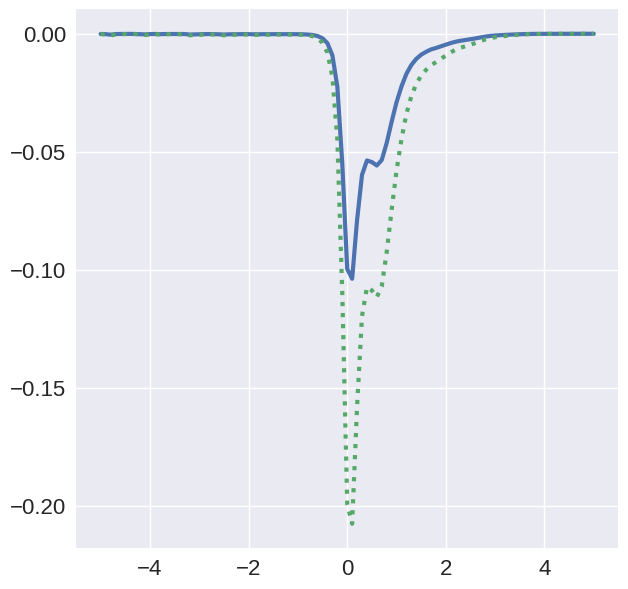

In [25]:
plt.plot(erange, ch_qa1.ImS[:, 0])
plt.plot(erange, imag(pt_q.S[:, 0]), ls=':')

0.9997331925175041

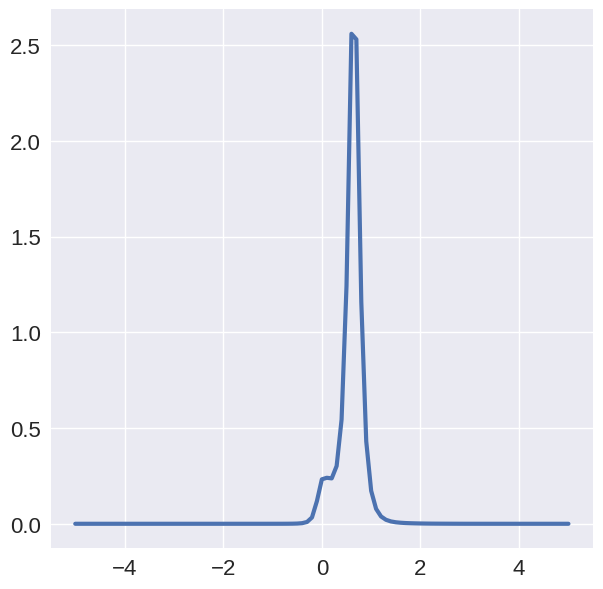

In [26]:
plt.plot(erange, pt_q.Rtab[:, 0])
trapz(pt_q.Rtab[:, 0], x=erange)

(0.0, 2.0)

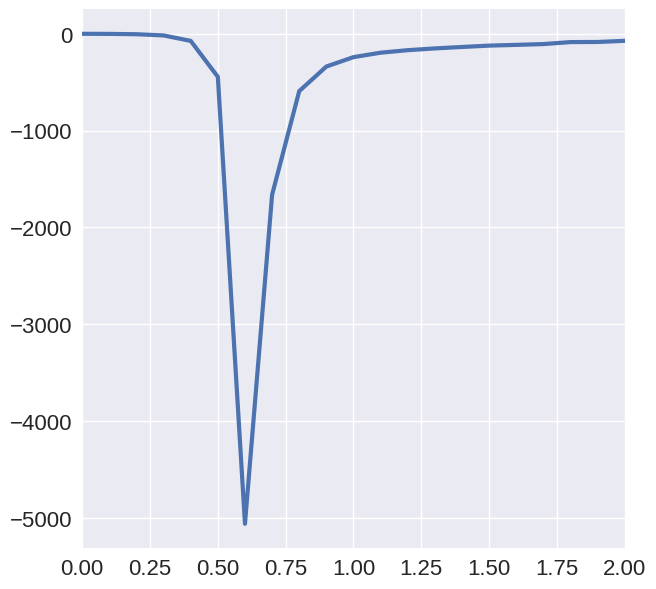

In [27]:
plt.plot(erange, imag(ch_qa1.TM[:, 0]))
plt.xlim(0, 2)

In [20]:
quark_bup.Rtab[:, 0] / quark_run.Rtab[:, 0]

array([0.95217879, 0.98484   , 0.99659466, 0.99583314, 0.9755638 ,
       0.97227193, 0.950351  , 1.05760321, 1.12971382, 1.1311207 ,
       1.09573843, 0.97030169, 0.99520245, 0.99284775, 1.07585312,
       1.06802734, 1.03013955, 1.01071431, 1.012092  , 1.01243406,
       1.02671705, 1.07206752, 1.03645784, 1.0474132 , 1.06052731,
       1.06057533, 1.0665812 , 1.10925638, 1.09772126, 1.05547169,
       1.06218646, 1.0565312 , 1.06303099, 1.09831755, 1.10139888,
       1.09017057, 1.09291488, 1.08261883, 1.06299492, 1.05017757,
       1.01540053, 0.96730983, 0.92512561, 0.90224029, 0.89585137,
       0.90296743, 0.91963354, 0.94617888, 0.98462128, 1.00363909,
       0.9823693 , 0.96168333, 0.96863603, 1.00842931, 1.05206191,
       1.04726921, 0.97899522, 0.96946767, 0.99868485, 1.02391145,
       1.03836033, 1.03978828, 1.04027961, 1.03471813, 1.02698254,
       1.01971756, 1.01416196, 1.00768531, 1.00217668, 0.99795747,
       0.99582604, 0.99938298, 1.0071481 , 1.01096104, 1.01284

In [28]:
quark_bup.Rtab[:, 0] - quark_run.Rtab[:, 0] 

array([-3.63663465e-07, -7.33049007e-07, -1.17967412e-06, -2.47966634e-06,
       -4.85546407e-08, -7.66546290e-08, -1.34283991e-07, -8.49012858e-08,
       -1.31931313e-07, -3.05500631e-07, -2.96423088e-07, -4.22548726e-07,
       -9.21355909e-07, -1.26947089e-06, -1.17454089e-07, -1.57600971e-07,
       -1.25883713e-06, -2.69089401e-06, -4.86984721e-06, -1.95471221e-06,
       -1.91028377e-06, -9.17402465e-07, -1.83781859e-06, -1.18889138e-06,
       -2.05364635e-06, -2.25333555e-06, -2.20216925e-06, -4.33304536e-06,
       -1.58059838e-06, -3.25150886e-06, -2.77826246e-06, -2.31577702e-06,
       -5.17561085e-06, -1.32508726e-06, -7.17242391e-07, -1.57201628e-07,
       -1.46308140e-06, -2.62924101e-06, -1.78485169e-06, -2.18146267e-06,
       -1.06515547e-06, -3.01525154e-06, -2.61711004e-06, -2.46878138e-06,
       -1.90329429e-06, -1.63155706e-06, -3.54163194e-06, -3.49106926e-06,
       -3.93023846e-06, -2.03304818e-06, -1.89265039e-06, -3.44637300e-06,
       -2.97831815e-06, -